In [1]:
import sys
sys.path.insert(0, "/home/broerman/crispy_shifty/")
from crispy_shifty.utils.io import gen_array_tasks

design_list_file = "/home/broerman/crispy_shifty/projects/DAB/round_2/design/03_fold_complex_all/folded_structures.list"

simulation_name = "04_fold_monomer"
output_path = f"/home/broerman/crispy_shifty/projects/DAB/round_2/design/{simulation_name}"

options = " ".join(
    [
        "out:level 100",
    ]
)
extra_kwargs = {
    "models": "all", 
    "score_prefix": "X_", 
    "chains_to_fold": "1", 
    "df_scores": "/home/broerman/crispy_shifty/projects/DAB/round_2/design/03_fold_complex_all/scores_combined.csv"
}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.folding.fold_general",
    design_list_file=design_list_file,
    output_path=output_path,
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    cores=1,
    memory="6G",
    queue="cpu",
    time="4:00:00",
)

Run the following command with your desired environment active:
sbatch -a 1-3939 /home/broerman/crispy_shifty/projects/DAB/round_2/design/04_fold_monomer/run.sh


In [1]:
import os
import sys
sys.path.insert(0, "/home/broerman/crispy_shifty")

simulation_name = "04_fold_monomer"
output_path = f"/home/broerman/crispy_shifty/projects/DAB/round_2/design/{simulation_name}"

In [2]:
from crispy_shifty.utils.io import collect_score_file

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

In [3]:
from crispy_shifty.utils.io import parse_scorefile_linear

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/19695 [00:00<?, ?it/s]

In [7]:
scores_df.parent.value_counts()

cs_203r2           1600
cs_207_left        1600
cs_207_right1      1600
cs_207_right2      1600
cs_287             1600
cs_269_twist       1595
cs_269_straight    1595
cs_292             1595
cs_243             1585
cs_221             1580
cs_230_straight    1360
cs_242              650
cs_244_straight     600
cs_244_twist        485
cs_201r1            295
cs_230_twist        140
cs_245              135
JHB_07ABr2           80
Name: parent, dtype: int64

In [4]:
# get parent pdb path
import pyrosetta.distributed.cluster as cluster
from tqdm.auto import tqdm

for path in tqdm(scores_df.index):
    pdb_path = cluster.get_scores_dict(path)["instance"]["tasks"]["pdb_path"]
    scores_df.loc[path, "input_pdb"] = pdb_path

  0%|          | 0/19695 [00:00<?, ?it/s]

In [2]:
import pandas as pd

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col=0)

6it [00:01,  3.98it/s]


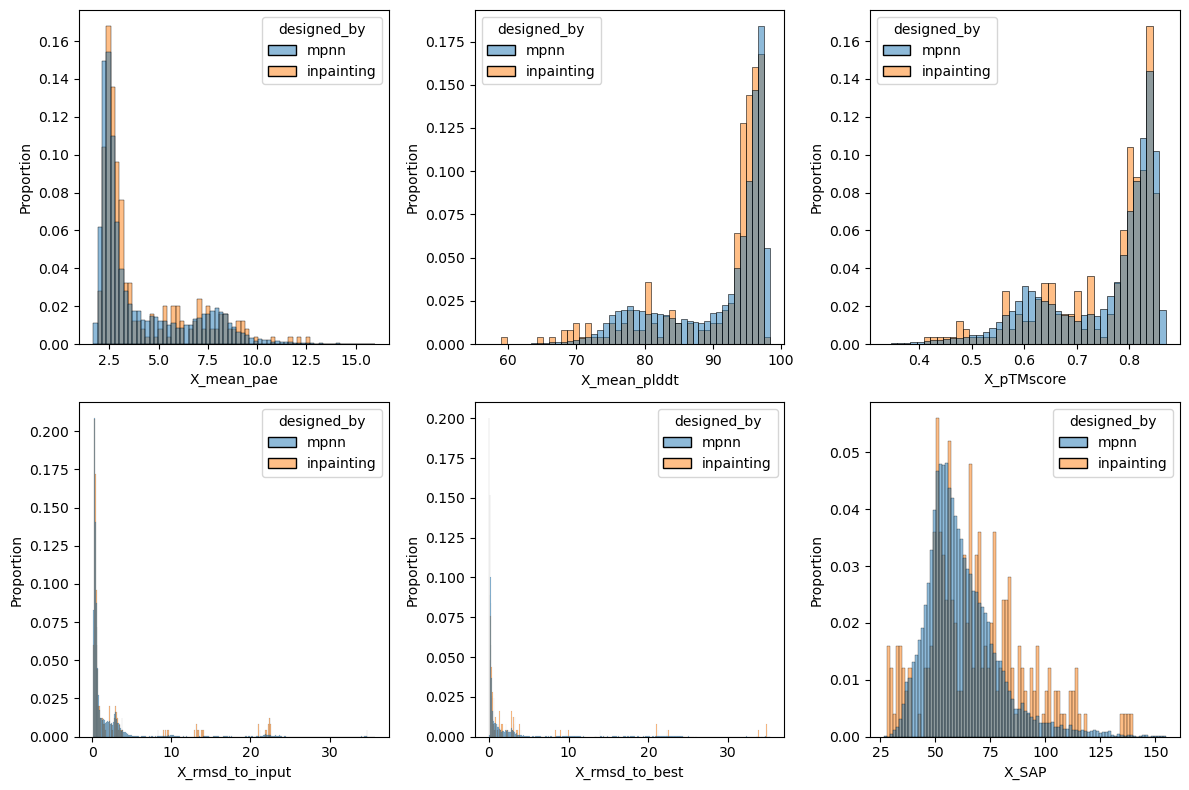

In [6]:
import matplotlib.pyplot as plt
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

cols = [
    "X_mean_pae",
    "X_mean_plddt",
    "X_pTMscore",
    "X_rmsd_to_input",
    "X_rmsd_to_best",
    "X_SAP"
]
the_fig = histplot_df(
    df=scores_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)
plt.savefig(os.path.join(output_path, "af2_scores_all.png"))

6it [00:00, 45.18it/s]


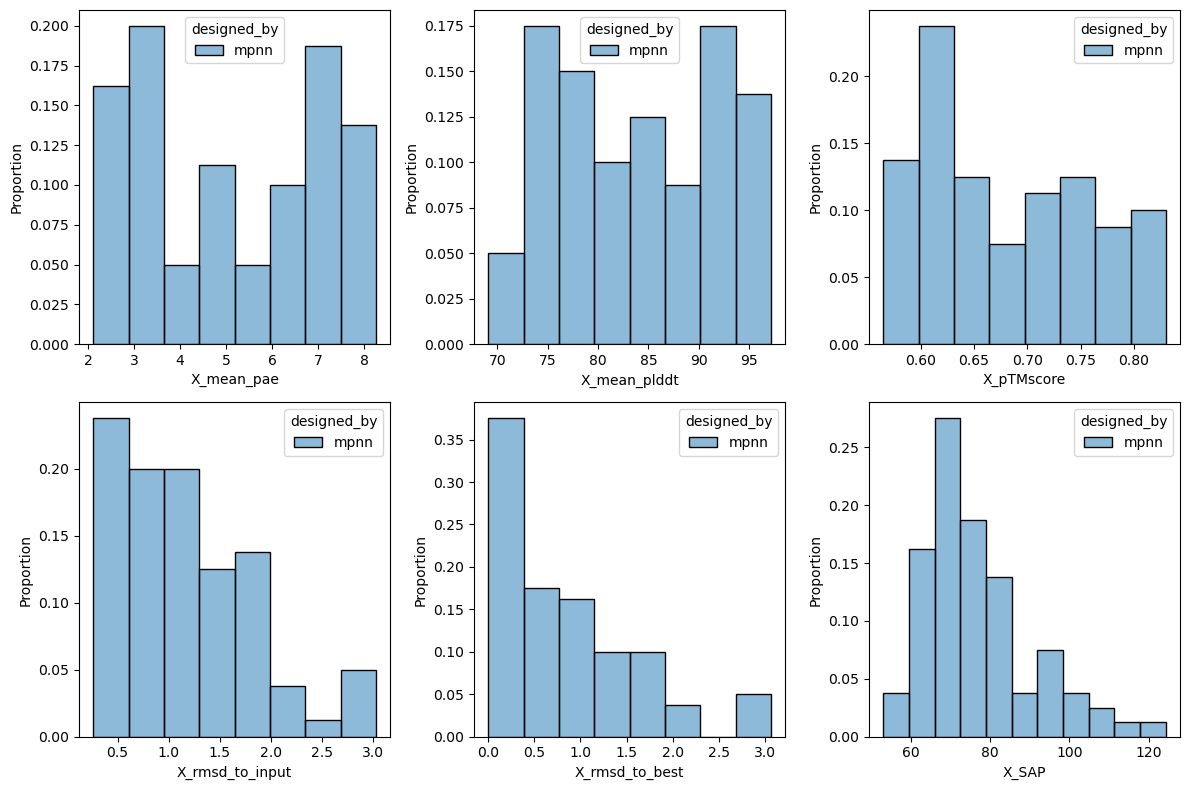

In [10]:
the_fig = histplot_df(
    df=scores_df.query("parent=='JHB_07ABr2'"),
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)

In [3]:
filtered_df = scores_df.query("X_mean_pae < 4 and X_mean_plddt > 90 and X_rmsd_to_input < 1 and X_SAP < 80")

In [4]:
filtered_df.parent.value_counts().sort_index()

JHB_07ABr2           22
cs_201r1            215
cs_203r2            485
cs_207_left        1046
cs_207_right1      1394
cs_207_right2      1559
cs_221              665
cs_230_straight     344
cs_230_twist         60
cs_242               27
cs_243             1329
cs_244_straight     355
cs_244_twist        167
cs_245              129
cs_269_straight    1057
cs_269_twist       1189
cs_287             1244
cs_292              690
Name: parent, dtype: int64

6it [00:03,  1.87it/s]


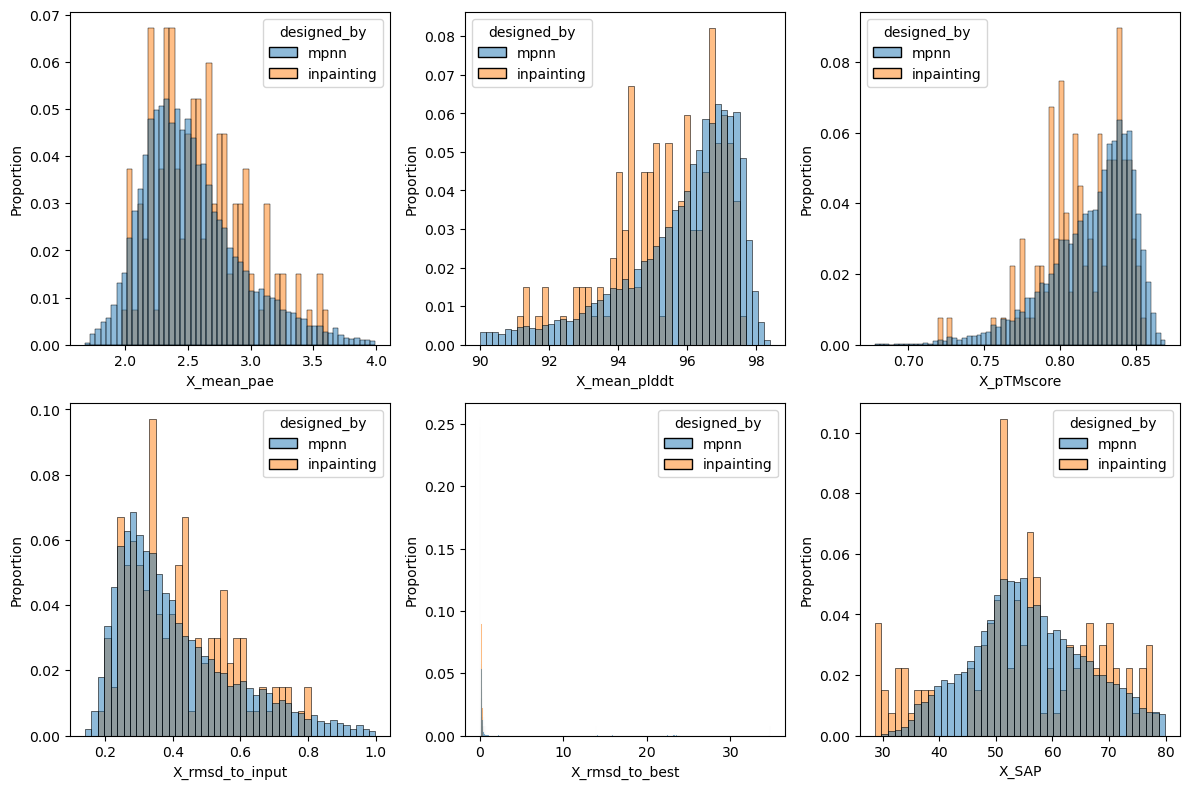

In [24]:
the_fig = histplot_df(
    df=filtered_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)
plt.savefig(os.path.join(output_path, "af2_scores.png"))

In [5]:
import numpy as np
X_cols = ['X_mean_pae', 'X_mean_plddt', 'X_pTMscore', 'X_rmsd_to_input', 'X_rmsd_to_best', 'X_SAP']
combined_dict = {}
for input_pdb in filtered_df.input_pdb.unique():
    state_df = filtered_df.query(f"input_pdb == '{input_pdb}'").sort_values("X_mean_plddt", ascending=False)
    new_row = state_df.iloc[0, :].copy()
    new_row[X_cols] = state_df[X_cols].mean()
    x_models = np.sort(state_df.X_model.unique())
    new_row["X_models"] = ','.join(x_models.astype(str))
    new_row["num_X_models"] = len(x_models)
    new_row["X_paths"] = ','.join(state_df.index)
    combined_dict[input_pdb] = new_row
combined_df = pd.DataFrame.from_dict(combined_dict, orient="index")

6it [00:03,  1.87it/s]


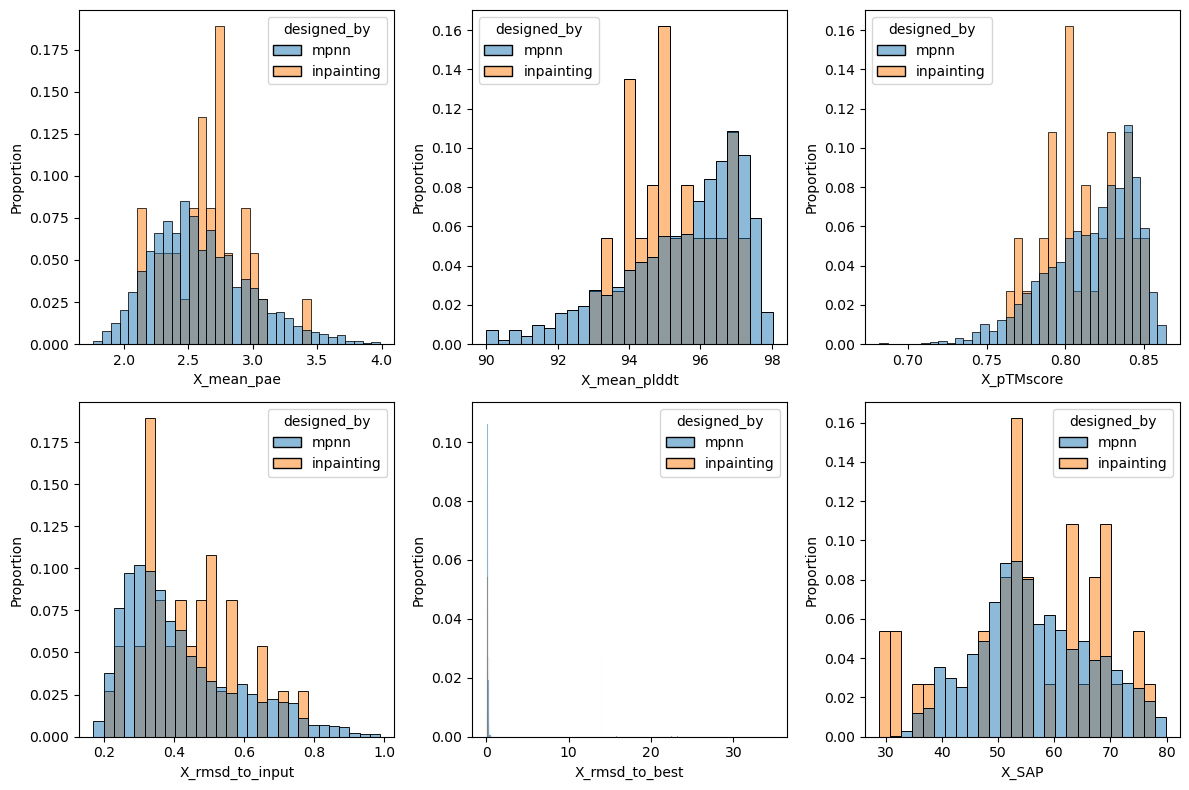

In [28]:
the_fig = histplot_df(
    df=combined_df,
    cols=X_cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)
plt.savefig(os.path.join(output_path, "af2_scores_X.png"))

In [6]:
print(len(combined_df))
combined_df = combined_df.query("X_rmsd_to_best < 1")
print(len(combined_df))

3062
3010


In [7]:
combined_df.parent.value_counts().sort_index()

JHB_07ABr2           8
cs_201r1            53
cs_203r2           173
cs_207_left        282
cs_207_right1      311
cs_207_right2      320
cs_221             215
cs_230_straight    121
cs_230_twist        19
cs_242              11
cs_243             286
cs_244_straight     89
cs_244_twist        53
cs_245              27
cs_269_straight    244
cs_269_twist       286
cs_287             300
cs_292             212
Name: parent, dtype: int64

In [14]:
target_representation = 40

filtered_comb_df = pd.DataFrame()
for parent in combined_df.parent.unique():
    parent_df = combined_df.query(f"parent == '{parent}'")
    for num_models in range(5, 0, -1):
        selected_df = parent_df.query(f"num_X_models >= {num_models}")
        if len(selected_df) >= target_representation:
            break
    filtered_comb_df = pd.concat([filtered_comb_df, selected_df])

In [15]:
filtered_comb_df.parent.value_counts().sort_index()

JHB_07ABr2           8
cs_201r1            47
cs_203r2            52
cs_207_left        128
cs_207_right1      230
cs_207_right2      293
cs_221              61
cs_230_straight     73
cs_230_twist        19
cs_242              11
cs_243             215
cs_244_straight     49
cs_244_twist        53
cs_245              27
cs_269_straight    169
cs_269_twist       162
cs_287             163
cs_292              55
Name: parent, dtype: int64

In [39]:
filtering_cols = [
    ("Y_mean_plddt", False),
    ("Y_mean_pae", True),
    ("Y_mean_pae_interaction", True),
    ("X_mean_plddt", False),
    ("X_mean_pae", True),
    ("X_SAP", True),
]

target_representation = 8

all_parents = set(filtered_comb_df.parent.values)
parent_dfs = []
for parent in all_parents:
    parent_df = filtered_comb_df[filtered_comb_df.parent == parent]

    if len(parent_df) > target_representation:
        # find the 10 designs which have all filtering metrics above the quantile cutoff
        filtering_df = pd.DataFrame(columns=[col for col, _ in filtering_cols])
        for col, minimize in filtering_cols:
            if minimize:
                filtering_df[col] = -parent_df[col]
            else:
                filtering_df[col] = parent_df[col]

        filtered_quantile_df = filtering_df
        df_len = len(filtered_quantile_df)
        q = 0.5
        min_q = 0
        max_q = 1
        n_iter = 0
        while df_len != target_representation:
            filtered_quantile_df = filtering_df[filtering_df > filtering_df.quantile(q)].dropna()
            df_len = len(filtered_quantile_df)
            if n_iter > 1000:
                # if it's impossible to distinguish among designs, just take the best by plddt
                filtered_quantile_df = filtering_df[filtering_df > filtering_df.quantile(min_q)].dropna().sort_values(by="Y_mean_plddt", ascending=False).head(target_representation)
                print(f"iteration limit reached for inpaint id {parent} with {df_len} designs at quantile {q}, min_q {min_q}, max_q {max_q}")
                break
            if df_len < target_representation:
                max_q = q
                q = (max_q + min_q) / 2
            elif df_len > target_representation:
                min_q = q
                q = (max_q + min_q) / 2
            n_iter += 1
        
        parent_df = parent_df.loc[filtered_quantile_df.index, :]

    parent_dfs.append(parent_df)

filtered_comb_best_df = pd.concat(parent_dfs)

iteration limit reached for inpaint id cs_242 with 6 designs at quantile 2.3331590462580472e-302, min_q 0, max_q 4.6663180925160944e-302


In [40]:
filtered_comb_best_df.parent.value_counts().sort_index()

JHB_07ABr2         8
cs_201r1           8
cs_203r2           8
cs_207_left        8
cs_207_right1      8
cs_207_right2      8
cs_221             8
cs_230_straight    8
cs_230_twist       8
cs_242             6
cs_243             8
cs_244_straight    8
cs_244_twist       8
cs_245             8
cs_269_straight    8
cs_269_twist       8
cs_287             8
cs_292             8
Name: parent, dtype: int64

In [41]:
from IPython.display import display
with pd.option_context(
    'display.max_columns', None,
):
    display(filtered_comb_best_df)

,SAP,X_SAP,X_mean_pae,X_mean_pae_interaction,X_mean_pae_intra_chain,X_mean_pae_intra_chain_A,X_mean_plddt,X_model,X_pTMscore,X_recycles,X_rmsd_to_best,X_rmsd_to_input,X_seed,X_tol,X_type,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_models,Y_pTMscore,Y_paths,Y_recycles,Y_rmsd_to_best,Y_rmsd_to_input,Y_rmsd_to_reference,Y_seed,Y_tol,contigs,designed_by,dslf_fa13,elapsed_time,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,fragment_len,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,inpaint_length,inpaint_mean_lddt,inpaint_seq_resis,inpaint_str_resis,input_pdb,len_dab,lk_ball_wtd,mean_pae,mean_pae_interaction,mean_pae_intra_chain,mean_pae_intra_chain_A,mean_plddt,model,mpnn_design_area,mpnn_temperature,num_Y_models,omega,pTMscore,p_aa_pp,parent,pro_close,rama_prepro,recycles,ref,rmsd_to_input,sampled_mask,seed,tag,tol,total_length,total_score,type,yhh_planarity,X_models,num_X_models,X_paths
/home/broerman/crispy_shifty/projects/DAB/round_2/design/03_fold_complex_all/decoys/0019/03_fold_complex_all_ed0ab741155a46029caf84eee69f01ce.pdb.bz2,48.328617,64.400952,2.573502,NaN,2.326492,2.326492,95.894273,2,0.826332,3.0,0.144640,0.310040,0,0.085785,monomer_ptm,2.777217,3.158703,3.229135,2.850659,2.303345,2.194691,2.411998,96.903158,5,"1,3,5",0.936602,/home/broerman/crispy_shifty/projects/DAB/roun...,3.0,1.000000e-07,0.453986,0.466394,0,0.058001,"A1-234,0;11-11,B246-249,23-25,C272-275,12-14,D...",mpnn,0.0,70.780563,-468.639984,168.731354,-138.315735,156.807266,14.867022,550.623352,346.237305,4.0,-0.184016,0.000000,-3.863514,-72.313248,48.0,0.794922,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,16,17,18,19,20,21,22,2...",/home/broerman/crispy_shifty/projects/DAB/roun...,84,-11.046981,2.437515,NaN,2.326492,2.326492,96.567322,2,selection,0.1,3,12.090750,0.837624,-17.334419,cs_292,0.575313,-30.599688,3.0,16.480940,0.325149,"A1-234,0;11-11,B246-249,24-24,C272-275,13-13,D...",0,tmp,0.085785,318.0,86.345566,monomer_ptm,2.728434e-07,"1,2,3,4,5",5,/home/broerman/crispy_shifty/projects/DAB/roun...
/home/broerman/crispy_shifty/projects/DAB/round_2/design/03_fold_complex_all/decoys/0019/03_fold_complex_all_96c06852bb634a50834397cb9eb8aa23.pdb.bz2,47.886662,64.128863,2.466033,NaN,2.277873,2.277873,96.236470,2,0.828718,3.0,0.161532,0.326536,0,0.098292,monomer_ptm,2.790366,3.176794,3.302540,2.861248,2.331336,2.235660,2.427011,96.806872,5,"1,3,5",0.935538,/home/broerman/crispy_shifty/projects/DAB/roun...,3.0,1.000000e-07,0.545095,0.533200,0,0.071112,"A1-234,0;11-11,B246-249,23-25,C272-275,12-14,D...",mpnn,0.0,68.525169,-458.962555,171.382782,-128.588654,157.057571,12.890640,560.506226,334.801086,4.0,-0.205344,0.000000,-0.957028,-71.562599,48.0,0.794922,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,16,17,18,19,20,21,22,2...",/home/broerman/crispy_shifty/projects/DAB/roun...,84,-10.696001,2.382200,NaN,2.277873,2.277873,96.625534,2,selection,0.1,3,11.580586,0.828839,-18.421890,cs_292,0.415526,-33.163692,3.0,17.454809,0.371975,"A1-234,0;11-11,B246-249,24-24,C272-275,13-13,D...",0,tmp,0.098292,318.0,102.380882,monomer_ptm,6.041378e-08,"1,2,3,4,5",5,/home/broerman/crispy_shifty/projects/DAB/roun...
/home/broerman/crispy_shifty/projects/DAB/round_2/design/03_fold_complex_all/decoys/0019/03_fold_complex_all_aec10f20db714e5d8926e1a65bf51175.pdb.bz2,46.097054,60.758566,2.581378,NaN,2.279099,2.279099,95.873140,2,0.830611,3.0,0.170850,0.322460,0,0.092743,monomer_ptm,2.795445,3.185147,3.268765,2.881772,2.331356,2.227126,2.435586,96.831418,5,"1,3,5",0.936228,/home/broerman/crispy_shifty/projects/DAB/roun...,3.0,1.000000e-07,0.480627,0.486887,0,0.067355,"A1-234,0;11-11,B246-249,23-25,C272-275,12-14,D...",mpnn,0.0,70.973572,-469.920807,187.228897,-142.743164,168.322952,14.788344,627.381348,352.264984,4.0,-2.257389,0.000000,-0.110283,-71.884377,48.0,0.794922

In [42]:
with open(os.path.join(output_path, "selected_structures.list"), "w") as f:
    for path in filtered_comb_best_df.index:
        print(path, file=f)

In [44]:
# copy designs
import bz2
from collections import defaultdict

# use this to generate unique and informative filenames
parent_counts = defaultdict(lambda: 0)

for index, row in filtered_comb_best_df.iterrows():
    out_X = f"{output_path}/selected_states/{row.parent}_{parent_counts[row.parent]:02d}_X_{row.X_mean_plddt:.01f}_{row.X_mean_pae:.02f}_{row.X_SAP:.02f}.pdb"
    out_Y = f"{output_path}/selected_states/{row.parent}_{parent_counts[row.parent]:02d}_Y_{row.Y_mean_plddt:.01f}_{row.Y_mean_pae:.02f}_{row.Y_mean_pae_interaction:.02f}.pdb"
    parent_counts[row.parent] += 1
    with open(row["X_paths"].split(',')[0], 'rb') as f_in:
        with open(out_X, 'wb') as f_out:
            f_out.write(bz2.decompress(f_in.read()))
    with open(index, 'rb') as f_in:
        with open(out_Y, 'wb') as f_out:
            f_out.write(bz2.decompress(f_in.read()))

The best designs were often different mpnn sequences for the same inpainting backbone. Let's get some more diversity in here.

In [19]:
# get inpaint pdb path
import pyrosetta.distributed.cluster as cluster
from tqdm.auto import tqdm

for index in tqdm(filtered_comb_df.index):
    path = index
    for _ in range(3):
        path = cluster.get_scores_dict(path)["instance"]["tasks"]["pdb_path"].split("____")[0]
    filtered_comb_df.loc[index, "inpaint_id"] = path.split("_")[-1].split(".")[0]

  0%|          | 0/1815 [00:00<?, ?it/s]

In [22]:
filtered_comb_df.to_csv(os.path.join(output_path, "scores_combined.csv"))

In [ ]:
# first get the best of each inpaint

filtering_cols = [
    ("Y_mean_plddt", False),
    # ("Y_mean_pae", True),
    ("Y_mean_pae_interaction", True),
    ("X_mean_plddt", False),
    # ("X_mean_pae", True),
    ("X_SAP", True),
]

target_representation = 1

all_parents = set(filtered_comb_df.inpaint_id.values)
parent_dfs = []
for parent in tqdm(all_parents):
    parent_df = filtered_comb_df[filtered_comb_df.inpaint_id == parent]

    if len(parent_df) > target_representation:
        # find the 10 designs which have all filtering metrics above the quantile cutoff
        filtering_df = pd.DataFrame(columns=[col for col, _ in filtering_cols])
        for col, minimize in filtering_cols:
            if minimize:
                filtering_df[col] = -parent_df[col]
            else:
                filtering_df[col] = parent_df[col]

        filtered_quantile_df = filtering_df
        df_len = len(filtered_quantile_df)
        q = 0.5
        min_q = 0
        max_q = 1
        n_iter = 0
        while df_len != target_representation:
            filtered_quantile_df = filtering_df[filtering_df > filtering_df.quantile(q)].dropna()
            df_len = len(filtered_quantile_df)
            if n_iter > 100:
                # if it's impossible to distinguish among designs, just take the best by plddt
                filtered_quantile_df = filtering_df[filtering_df > filtering_df.quantile(min_q)].dropna().sort_values(by="Y_mean_plddt", ascending=False).head(target_representation)
                print(f"iteration limit reached for inpaint id {parent} with {df_len} designs at quantile {q}, min_q {min_q}, max_q {max_q}")
                break
            if df_len < target_representation:
                max_q = q
                q = (max_q + min_q) / 2
            elif df_len > target_representation:
                min_q = q
                q = (max_q + min_q) / 2
            n_iter += 1
        
        parent_df = parent_df.loc[filtered_quantile_df.index, :]

    parent_dfs.append(parent_df)

filtered_comb_best_inp_df = pd.concat(parent_dfs)

In [28]:
# then get the best of those

filtering_cols = [
    ("Y_mean_plddt", False),
    # ("Y_mean_pae", True),
    ("Y_mean_pae_interaction", True),
    ("X_mean_plddt", False),
    # ("X_mean_pae", True),
    ("X_SAP", True),
]

target_representation = 4

all_parents = set(filtered_comb_best_inp_df.parent.values)
parent_dfs = []
for parent in all_parents:
    parent_df = filtered_comb_best_inp_df[filtered_comb_best_inp_df.parent == parent]

    if len(parent_df) > target_representation:
        # find the 10 designs which have all filtering metrics above the quantile cutoff
        filtering_df = pd.DataFrame(columns=[col for col, _ in filtering_cols])
        for col, minimize in filtering_cols:
            if minimize:
                filtering_df[col] = -parent_df[col]
            else:
                filtering_df[col] = parent_df[col]

        filtered_quantile_df = filtering_df
        df_len = len(filtered_quantile_df)
        q = 0.5
        min_q = 0
        max_q = 1
        n_iter = 0
        while df_len != target_representation:
            filtered_quantile_df = filtering_df[filtering_df > filtering_df.quantile(q)].dropna()
            df_len = len(filtered_quantile_df)
            if n_iter > 1000:
                # if it's impossible to distinguish among designs, just take the best by plddt
                filtered_quantile_df = filtering_df[filtering_df > filtering_df.quantile(min_q)].dropna().sort_values(by="Y_mean_plddt", ascending=False).head(target_representation)
                print(f"iteration limit reached for inpaint id {parent} with {df_len} designs at quantile {q}, min_q {min_q}, max_q {max_q}")
                break
            if df_len < target_representation:
                max_q = q
                q = (max_q + min_q) / 2
            elif df_len > target_representation:
                min_q = q
                q = (max_q + min_q) / 2
            n_iter += 1
        
        parent_df = parent_df.loc[filtered_quantile_df.index, :]

    parent_dfs.append(parent_df)

filtered_comb_best_div_df = pd.concat(parent_dfs)

iteration limit reached for inpaint id cs_230_twist with 2 designs at quantile 2.3331590462580472e-302, min_q 0, max_q 4.6663180925160944e-302


In [29]:
filtered_comb_best_div_df.parent.value_counts().sort_index()

JHB_07ABr2         4
cs_201r1           4
cs_203r2           4
cs_207_left        4
cs_207_right1      4
cs_207_right2      4
cs_221             4
cs_230_straight    4
cs_230_twist       2
cs_242             3
cs_243             4
cs_244_straight    4
cs_244_twist       4
cs_245             4
cs_269_straight    4
cs_269_twist       4
cs_287             4
cs_292             4
Name: parent, dtype: int64

In [30]:
from IPython.display import display
with pd.option_context(
    'display.max_columns', None,
):
    display(filtered_comb_best_div_df)

,SAP,X_SAP,X_mean_pae,X_mean_pae_interaction,X_mean_pae_intra_chain,X_mean_pae_intra_chain_A,X_mean_plddt,X_model,X_pTMscore,X_recycles,X_rmsd_to_best,X_rmsd_to_input,X_seed,X_tol,X_type,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_models,Y_pTMscore,Y_paths,Y_recycles,Y_rmsd_to_best,Y_rmsd_to_input,Y_rmsd_to_reference,Y_seed,Y_tol,contigs,designed_by,dslf_fa13,elapsed_time,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,fragment_len,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,inpaint_length,inpaint_mean_lddt,inpaint_seq_resis,inpaint_str_resis,input_pdb,len_dab,lk_ball_wtd,mean_pae,mean_pae_interaction,mean_pae_intra_chain,mean_pae_intra_chain_A,mean_plddt,model,mpnn_design_area,mpnn_temperature,num_Y_models,omega,pTMscore,p_aa_pp,parent,pro_close,rama_prepro,recycles,ref,rmsd_to_input,sampled_mask,seed,tag,tol,total_length,total_score,type,yhh_planarity,X_models,num_X_models,X_paths,inpaint_id
/home/broerman/crispy_shifty/projects/DAB/round_2/design/03_fold_complex_all/decoys/0010/03_fold_complex_all_3351cd288c8e4ae18f53325b409e4dc6.pdb.bz2,44.500973,66.812920,2.807083,NaN,2.409578,2.409578,95.463899,2,0.830849,3.0,0.218636,0.448473,0,0.037060,monomer_ptm,3.852379,4.183816,4.137987,4.393257,3.085074,2.393646,3.776502,93.404247,1,"1,5",0.886770,/home/broerman/crispy_shifty/projects/DAB/roun...,3.0,1.000000e-07,1.002130,0.961213,0,0.458574,"A1-230,0;13-13,B244-247,27-29,C274-277,13-15,D...",mpnn,0.0,71.032593,-519.120361,162.256363,-154.013229,168.163834,13.286139,196.882278,354.041321,4.0,-3.156922,-0.160507,-1.018122,-83.800980,53.0,0.833496,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,18,19,20,21,22,2...",/home/broerman/crispy_shifty/projects/DAB/roun...,91,-10.985335,2.548551,NaN,2.409578,2.409578,96.359085,2,selection,0.1,2,15.337699,0.847630,-22.388681,cs_201r1,0.000000,-25.717127,3.0,20.128731,0.512833,"A1-230,0;13-13,B244-247,27-27,C274-277,13-13,D...",0,tmp,0.037060,321.0,-180.964539,monomer_ptm,0.000000e+00,"1,2,3,4,5",5,/home/broerman/crispy_shifty/projects/DAB/roun...,05e5972c23df4635852ce4ecea04ba94
/home/broerman/crispy_shifty/projects/DAB/round_2/design/03_fold_complex_all/decoys/0010/03_fold_complex_all_4687fd209c8c4c9496bb36c187ff5670.pdb.bz2,57.666691,72.490221,2.398809,NaN,2.182464,2.182464,97.086282,2,0.856693,3.0,0.144228,0.329659,0,0.031454,monomer_ptm,3.957097,4.297729,3.780035,4.327173,2.929095,2.155884,3.702307,93.271664,5,"1,5",0.882669,/home/broerman/crispy_shifty/projects/DAB/roun...,3.0,1.018953e+01,0.966746,0.917718,0,0.147216,"A1-230,0;13-13,B244-247,27-29,C274-277,13-15,D...",mpnn,0.0,72.386650,-534.096008,168.598618,-139.223099,179.417664,14.917951,140.481110,346.129974,4.0,-2.776679,0.000000,-2.620012,-81.661057,54.0,0.828613,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...","1,2,3,4,5,6,7,8,9,10,11,12,13,18,19,20,21,22,2...",/home/broerman/crispy_shifty/projects/DAB/roun...,92,-14.726521,2.297796,NaN,2.182464,2.182464,97.358566,2,selection,0.1,2,13.822986,0.860429,-21.819494,cs_201r1,4.804687,-13.866606,3.0,14.361130,0.343952,"A1-230,0;13-13,B244-247,28-28,C274-277,13-13,D...",0,tmp,0.031454,322.0,-211.310211,monomer_ptm,0.000000e+00,"1,2,3,4,5",5,/home/broerman/crispy_shifty/projects/DAB/roun...,77ca41b5c69847f495c77818a02c3808
/home/broerman/crispy_shifty/projects/DAB/round_2/design/03_fold_complex_all/decoys/0010/03_fold_complex_all_6843af5e96e744818e23b10d04da93f2.pdb.bz2,54.520699,72.698247,2.858549,NaN,2.423358,2.423358,95.476341,2,0.840108,3.0,0.179125,0.384608,0,0.089655,monomer_ptm,3.969371,4.308091,4.269346,4.346836,3.164277,2.539477,3.789077,93.354065,1,1,0.884936,/home/broerman/crispy_shifty/projects/DAB/roun...,3.0,1.098299e+01,0.935111,0.959068,0,0.824068,"A1-230,0;13-13,B244-247,27-29,C274-277,13-15,D...",mpnn,0.0,69.953499,-527.921082,148.072678,-138.407211,170.748016,14.749235,286.

In [32]:
with open(os.path.join(output_path, "selected_diverse_structures.list"), "w") as f:
    for path in filtered_comb_best_div_df.index:
        print(path, file=f)

In [33]:
# copy designs
import bz2
from collections import defaultdict

# use this to generate unique and informative filenames
parent_counts = defaultdict(lambda: 0)

for index, row in filtered_comb_best_div_df.iterrows():
    out_X = f"{output_path}/selected_div_states/{row.parent}_{parent_counts[row.parent]:02d}_X_{row.X_mean_plddt:.01f}_{row.X_mean_pae:.02f}_{row.X_SAP:.02f}.pdb"
    out_Y = f"{output_path}/selected_div_states/{row.parent}_{parent_counts[row.parent]:02d}_Y_{row.Y_mean_plddt:.01f}_{row.Y_mean_pae:.02f}_{row.Y_mean_pae_interaction:.02f}.pdb"
    parent_counts[row.parent] += 1
    with open(row["X_paths"].split(',')[0], 'rb') as f_in:
        with open(out_X, 'wb') as f_out:
            f_out.write(bz2.decompress(f_in.read()))
    with open(index, 'rb') as f_in:
        with open(out_Y, 'wb') as f_out:
            f_out.write(bz2.decompress(f_in.read()))